# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Инструкция по выполнению проекта**

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
1. Загрузите и подготовьте данные.
2. Обучите разные модели. Для каждой попробуйте различные гипепараметеры.
3. Проанализируйте скорость работы и качество моделей.

## Подготовка данных

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

pip install phik
import phik

In [4]:
df = pd.read_csv('/datasets/autos.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Обработка столбцов

Удалим те столбцы, которые не потребуются при анализе:
* DateCrawled
* RegistrationMonth
* DateCreated
* NumberOfPictures
* PostalCode
* LastSeen

In [6]:
df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 
         'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

Приведем названия столбцов к змеиному_регистру и поменяем порядок столбцов

In [7]:
df.columns = df.columns.str.lower()
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'notrepaired'],
      dtype='object')

In [8]:
columns = ['registrationyear', 'brand', 'model', 'vehicletype', 'gearbox', 
           'fueltype', 'power', 'kilometer', 'notrepaired', 'price']

df = df.reindex(columns=columns)

In [9]:
columns = {'registrationyear':'year', 
           'vehicletype':'vehicle_type', 
           'fueltype':'fuel_type', 
           'notrepaired':'not_repaired'}

df.rename(columns=columns, inplace=True)

In [10]:
df.head()

,year,brand,model,vehicle_type,gearbox,fuel_type,power,kilometer,not_repaired,price
0,1993,volkswagen,golf,NaN,manual,petrol,0,150000,NaN,480
1,2011,audi,NaN,coupe,manual,gasoline,190,125000,yes,18300
2,2004,jeep,grand,suv,auto,gasoline,163,125000,NaN,9800
3,2001,volkswagen,golf,small,manual,petrol,75,150000,no,1500
4,2008,skoda,fabia,small,manual,gasoline,69,90000,no,3600


### Обработка пропусков

In [11]:
df.isna().sum()

year                0
brand               0
model           19705
vehicle_type    37490
gearbox         19833
fuel_type       32895
power               0
kilometer           0
not_repaired    71154
price               0
dtype: int64

Заполним пропуски

In [12]:
df['model'] = df['model'].fillna('unknown')
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
df['gearbox'] = df['gearbox'].fillna('unknown')
df['fuel_type'] = df['fuel_type'].fillna('unknown')

In [13]:
df['not_repaired'].value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

Скорее всего, пропуски в столбце not_repaired означают отсутствие ремонта (т.е. yes)

Также в этом столбце имеет смысл привести значения к типу bool

In [14]:
df.loc[(df['not_repaired'] == 'yes'), 'not_repaired'] = 1
df.loc[(df['not_repaired'] == 'no'), 'not_repaired'] = 0

df['not_repaired'] = df['not_repaired'].fillna(1).astype(bool)

df['not_repaired'].value_counts()

False    247161
True     107208
Name: not_repaired, dtype: int64

### Обработка значений

Определим функцию для построения диаграммы "ящик с усами"

In [15]:
sns.set(rc={'figure.figsize':(10,5)})

def display_boxplot(data, title):
    sns.boxplot(x=data)
    plt.title(title)
    plt.show()

In [16]:
def display_histplot(data, bins, title):
    sns.histplot(data=data, bins=bins)
    plt.title(title)
    plt.show()

#### Столбец year

In [17]:
df.year.describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: year, dtype: float64

Построим "ящик с усами"

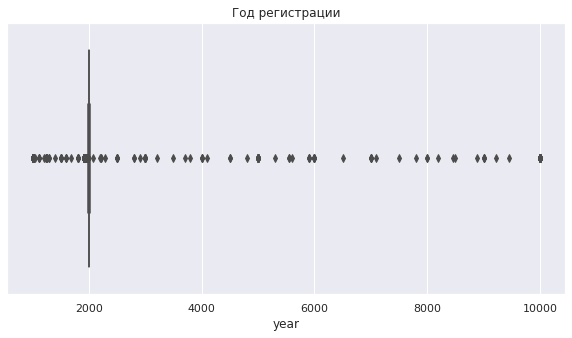

In [18]:
display_boxplot(df.year, 'Год регистрации')

Для начала посмотрим на гостей из будущего (данные выгружены в 2016 году)

In [19]:
df.query('year>2016').shape[0]

14530

Очень много

Интересно посмотреть "критическую точку" - 2017 и 2016 годы

In [20]:
df.query('year==2017').shape[0]

10441

In [21]:
df.query('year==2016').shape[0]

9599

Да уж, 2017 даже больше, чем 2016

Наверняка это не ошибка, а имеющие смысл данные, например, как в 2021 году продают литературу с датой издания 2022

Удалим данные от 2018 и выше

In [22]:
df.drop(df.loc[df['year']>2017].index, inplace=True)

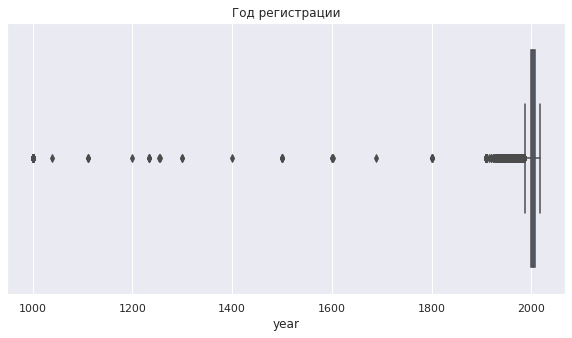

In [23]:
display_boxplot(df.year, 'Год регистрации')

Первый автомобиль создан в 1886 году, удалим неисторичные выбросы и еще раз посмотрим нижние значения

In [24]:
df.drop(df.loc[df['year']<1886].index, inplace=True)

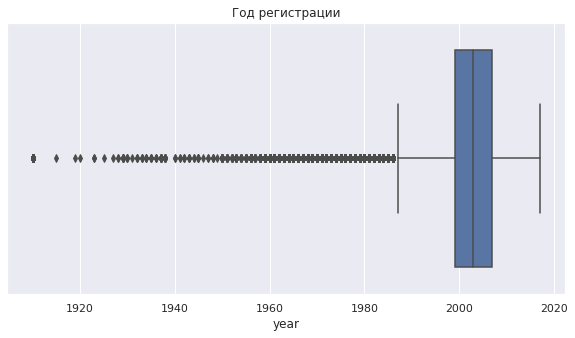

In [25]:
display_boxplot(df.year, 'Год регистрации')

In [26]:
df.query('year<1985').shape[0]

5382

Возьмем 1985 год как минимальный

In [27]:
df.drop(df.loc[df['year']<1985].index, inplace=True)

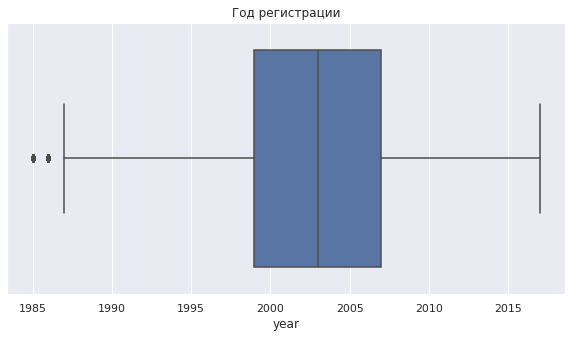

In [28]:
display_boxplot(df.year, 'Год регистрации')

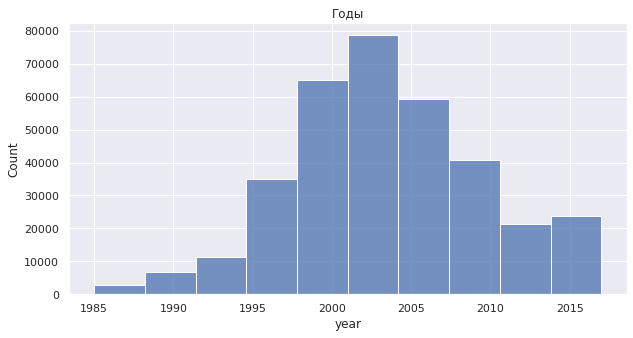

In [29]:
display_histplot(df.year, 10, 'Годы')

In [30]:
df.year.describe()

count    344832.000000
mean       2003.379150
std           6.269945
min        1985.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2017.000000
Name: year, dtype: float64

#### Столбец brand

In [31]:
df.brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [32]:
df.brand.describe()

count         344832
unique            40
top       volkswagen
freq           74893
Name: brand, dtype: object

#### Столбец model

In [33]:
df.model.describe()

count     344832
unique       248
top         golf
freq       28598
Name: model, dtype: object

Очень много моделей, нужно уменьшить количество, т.к это категориальный признак

In [34]:
df.model.value_counts()

golf                  28598
other                 22070
3er                   19547
unknown               17884
polo                  12840
                      ...  
elefantino               11
i3                        8
kalina                    6
rangerover                4
range_rover_evoque        2
Name: model, Length: 248, dtype: int64

In [35]:
df.model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Мы видим, что каких-то моделей десятки тысяч, а каких-то всего несколько штук, при этом самих моделей очень много

Есть значение other и unknown (которым мы заменили NaN), их можно объединить, в данном случае они имеют один смысл

Такие значения, как 'range_rover', 'range_rover_evoque', 'range_rover_sport', 'rangerover', можно заменить одним

In [36]:
df.loc[((df['model'] == 'range_rover_evoque') | 
        (df['model'] == 'range_rover_sport') | 
        (df['model'] == 'rangerover')), 
       'model'] = 'range_rover'

Посмотрим, сколько категорий имеют меньше 300 единиц на рынке и сколько всего это автомобилей

In [37]:
df.model.value_counts().to_frame().loc[df.model.value_counts().to_frame()['model']<1000].shape[0]

189

In [38]:
df.model.value_counts().to_frame().loc[df.model.value_counts().to_frame()['model']<1000].sum()

model    61015
dtype: int64

Попробуем сократить число таких моделей, а также объединить категории other и unknown - имеют один смысл

In [39]:
models = df.model.value_counts().to_frame().loc[df.model.value_counts().to_frame()['model']<1000].index

for model in models:
    df.loc[df['model'] == model, 'model'] = 'other'
    
df.loc[df['model'] == 'unknown', 'model'] = 'other'

In [40]:
df[df['model']=='other'].shape[0]

100969

In [41]:
df.model.value_counts().count()

55

#### Столбец vehicle_type

In [42]:
df.vehicle_type.value_counts()

sedan          89710
small          79360
wagon          64962
unknown        32637
bus            28549
convertible    19580
coupe          15270
suv            11715
other           3049
Name: vehicle_type, dtype: int64

#### Столбец gearbox

In [43]:
df.gearbox.value_counts()

manual     262003
auto        64699
unknown     18130
Name: gearbox, dtype: int64

#### Столбец fuel_type

In [44]:
df.fuel_type.value_counts()

petrol      210760
gasoline     97721
unknown      30096
lpg           5223
cng            556
hybrid         230
other          158
electric        88
Name: fuel_type, dtype: int64

#### Столбец power

In [45]:
df.power.describe()

count    344832.000000
mean        110.867054
std         187.100003
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Мы видим, что в этом столбце есть аномальные значений, исследуем данные

*По информации с профильных ресурсов, автомобили 1930-х имели приблизительно от 40 л.с. (ГАЗ-4) до 115 л.с. (Bentley 3.5 Litre)*

*Самые мощные современные автомобили имеют 1750-2000 л.с. (и вряд ли такие продаются на обычных сайтах)*

*Средний современный автомобиль 100-250 л.с.*

Построим диаграмму "ящик с усами"

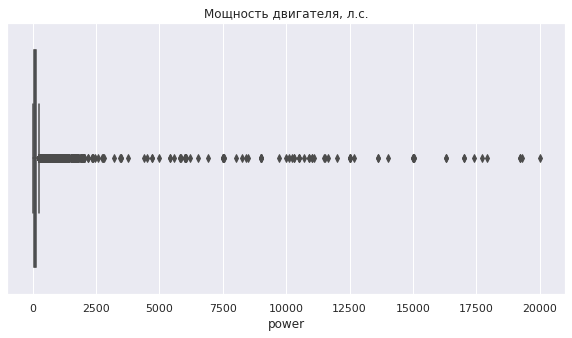

In [46]:
display_boxplot(df.power, 'Мощность двигателя, л.с.')

Так много выбросов, что кроме них практически ничего не видно

Сначала избавимся от слишком больших величин

Значения выше 10000 могут быть опечаткой, попробуем разделить их на 100

In [47]:
df.loc[(df.power >= 10000), 'power'] = df.power / 100

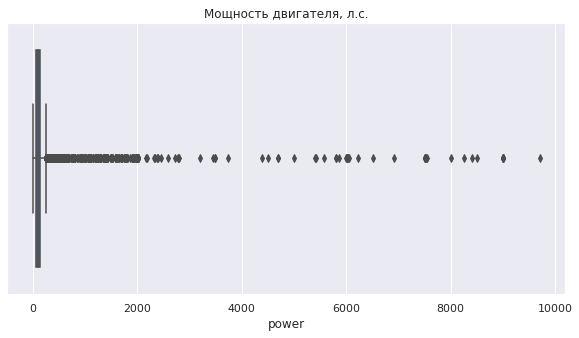

In [48]:
display_boxplot(df.power, 'Мощность двигателя, л.с.')

Приличная диаграмма постепенно вырисовывается

Посмотрим описательные статистики

In [49]:
df.power.describe()

count    344832.000000
mean        109.190702
std         106.142539
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max        9710.000000
Name: power, dtype: float64

Медиана 105, заменим данные выше 2000 этим значением

In [50]:
df.loc[(df.power >= 2000), 'power'] = df.power.median()

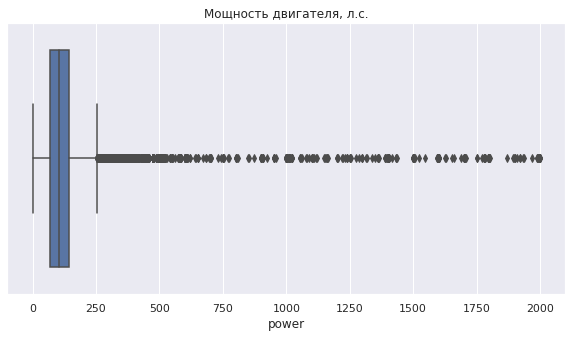

In [51]:
display_boxplot(df.power, 'Мощность двигателя, л.с.')

Значения от 250 также заменим медианой

In [52]:
df.loc[(df.power >= 250), 'power'] = df.power.median()

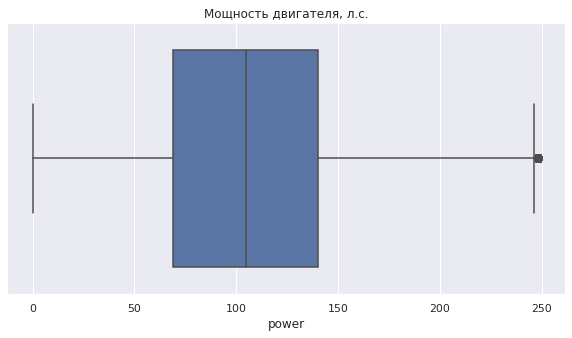

In [53]:
display_boxplot(df.power, 'Мощность двигателя, л.с.')

Как мы помним, автомобили выше 40 л.с. уже были в 1930-е годы. Также заменим медианой

In [54]:
df.loc[(df.power < 40), 'power'] = df.power.median()

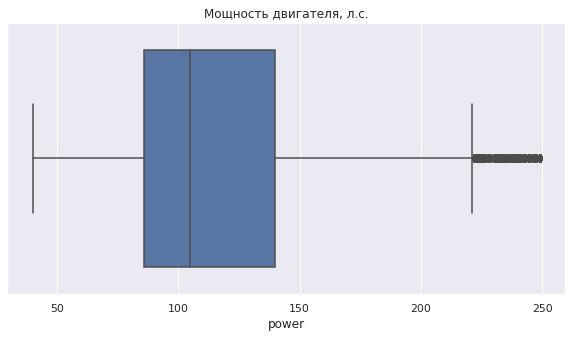

In [55]:
display_boxplot(df.power, 'Мощность двигателя, л.с.')

In [56]:
df.power.describe()

count    344832.000000
mean        114.644734
std          41.924730
min          40.000000
25%          86.000000
50%         105.000000
75%         140.000000
max         249.000000
Name: power, dtype: float64

Посмотрим уникальные значения после обработки

In [57]:
df.power.value_counts()

105.00    56578
75.00     23506
60.00     15533
150.00    14418
101.00    13117
          ...  
116.35        1
110.25        1
179.32        1
111.11        1
193.12        1
Name: power, Length: 246, dtype: int64

Очень много значений и встречаются какие-то дробные

Построим гистограмму

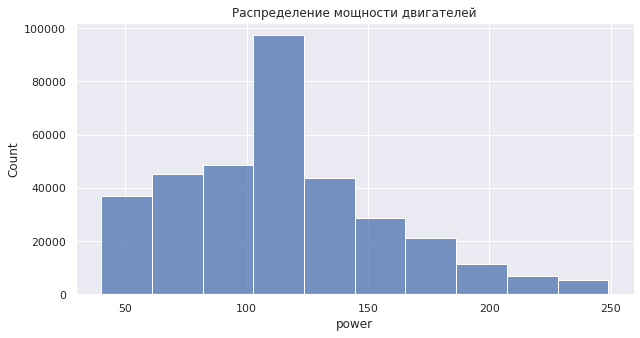

In [58]:
display_histplot(df.power, 10, 'Распределение мощности двигателей')

Попробуем разделить данные на категории

In [59]:
interval_range = pd.interval_range(start=39,
                                   freq=10,
                                   end=260)

df.power = pd.cut(df.power, bins=interval_range).astype(str)

df.head()

,year,brand,model,vehicle_type,gearbox,fuel_type,power,kilometer,not_repaired,price
0,1993,volkswagen,golf,unknown,manual,petrol,"(99, 109]",150000,True,480
1,2011,audi,other,coupe,manual,gasoline,"(189, 199]",125000,True,18300
2,2004,jeep,other,suv,auto,gasoline,"(159, 169]",125000,True,9800
3,2001,volkswagen,golf,small,manual,petrol,"(69, 79]",150000,False,1500
4,2008,skoda,fabia,small,manual,gasoline,"(59, 69]",90000,False,3600


In [60]:
df.power.value_counts()

(99, 109]     85221
(69, 79]      28940
(59, 69]      27574
(109, 119]    23676
(139, 149]    21910
(119, 129]    18736
(89, 99]      18593
(169, 179]    17603
(49, 59]      16915
(149, 159]    16797
(129, 139]    14942
(79, 89]      13215
(159, 169]     9901
(189, 199]     6997
(229, 239]     4507
(199, 209]     4493
(39, 49]       4283
(209, 219]     3465
(179, 189]     3127
(219, 229]     3103
(239, 249]      834
Name: power, dtype: int64

Прекрасно - избавились от выбросов и получили категории мощности двигателя

#### Столбец kilometer

In [61]:
df.kilometer.value_counts().sort_values()

10000       1054
20000       3764
30000       4253
40000       4722
5000        5527
50000       5962
60000       7182
70000       8267
80000       9669
90000      11186
100000     14145
125000     35601
150000    233500
Name: kilometer, dtype: int64

Эти значения можно считать категориальными

#### Столбец price (целевой признак)

In [62]:
df.price.describe()

count    344832.000000
mean       4403.281734
std        4504.460267
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6380.000000
max       20000.000000
Name: price, dtype: float64

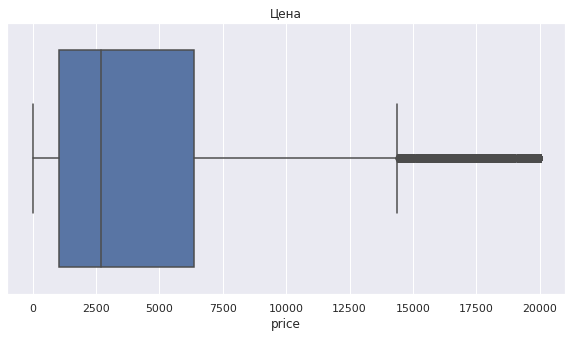

In [63]:
display_boxplot(df.price, 'Цена')

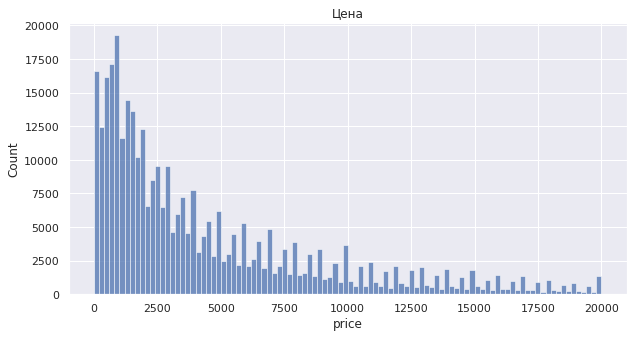

In [64]:
display_histplot(df.price, 100, 'Цена')

In [65]:
df.query('price==0').shape[0]

10109

Нулевые значения мы восстановить не можем, т.к. это может быть например ситуация, когда владелец снял авто с продажи

Так как это целевой признак, удалим эти значения, чтобы они не путали модели

In [66]:
df.drop(df.loc[df['price']==0].index, inplace=True)

In [67]:
df.price.describe()

count    334723.000000
mean       4536.265650
std        4505.518506
min           1.000000
25%        1200.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Все равно остались аномально низкие значения

Установим границу в 250 евро

In [68]:
df.query('price<250').shape[0]

8965

In [69]:
df.drop(df.loc[df['price']<250].index, inplace=True)

In [70]:
df.price.describe()

count    325758.000000
mean       4657.533844
std        4506.566334
min         250.000000
25%        1290.000000
50%        2990.000000
75%        6666.000000
max       20000.000000
Name: price, dtype: float64

### Обработка дубликатов

In [71]:
df.duplicated().sum()

48058

In [72]:
df.drop_duplicates(inplace=True)

### Корреляция

<AxesSubplot:>

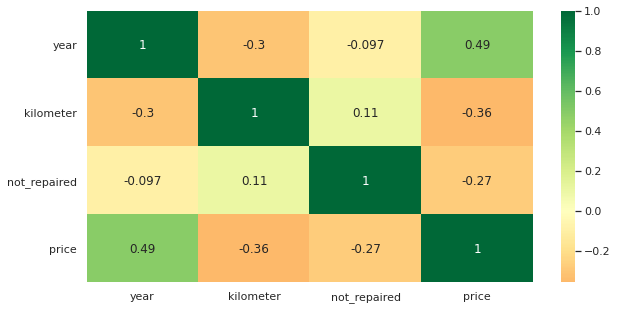

In [73]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)

Наблюдается довольно высокая корреляция между стоимостью автомобиля и годом регистрации

Попробуем другой метод визуализации

interval columns not set, guessing: ['year', 'kilometer', 'price']


<AxesSubplot:>

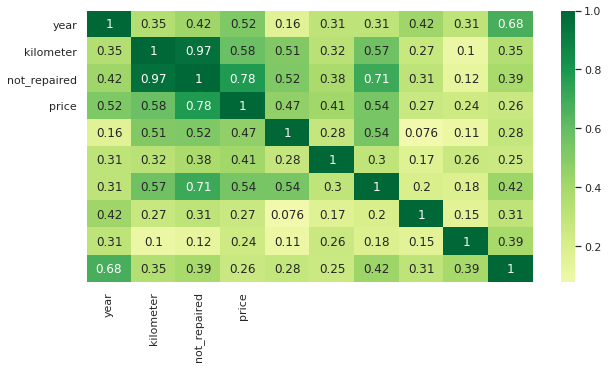

In [84]:
sns.heatmap(df.phik_matrix(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)

## Обучение моделей

### Подготовка данных

Разделим данные на обучающую и тестовую выборки

In [72]:
features = df.drop(['price'], axis=1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=17)

Модели CatBoost и LightGBM поддерживают работу с категориальными данными, поэтому скопируем features для работы с линейной регрессией

In [73]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()

Приведем признаки к формату category

In [74]:
categorical = ['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'power', 'kilometer']

In [75]:
features_train[categorical] = features_train[categorical].astype('category')
features_test[categorical] = features_test[categorical].astype('category')

### Функции для работы с моделями

Опишем функции, производящие обучение, предсказания и расчет времени и метрик

In [76]:
def fit_model(model, features, target):
    start = time.time()
    
    try:
        model.fit(features, target, verbose=False)
    except:
        model.fit(features, target)
        
    end = time.time()
    
    return {'model':model, 'fit_time':(end-start)}

In [77]:
def predict_values(model, features):
    start = time.time()
    
    predictions = model.predict(features)
    end = time.time()
    
    return {'predictions':predictions, 'prediction_time':(end-start)}

In [78]:
def display_metrics(fit_time, prediction_time, rmse):
    print('Время обучения модели:', fit_time)
    print('Время предсказания:', prediction_time)
    print('RMSE =', rmse)

### CatBoost

In [79]:
model = CatBoostRegressor(cat_features=categorical)

In [80]:
fit = fit_model(model, features_train, target_train)

In [81]:
predict = predict_values(model, features_test)

In [82]:
rmse = mean_squared_error(target_test, predict.get('predictions'), squared=False)

In [83]:
display_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

Время обучения модели: 211.00607228279114
Время предсказания: 0.5098991394042969
RMSE = 1725.079289083904


### LightGBM

In [84]:
model = lgb.LGBMRegressor(cat_feature=categorical)

In [85]:
fit = fit_model(model, features_train, target_train)

In [86]:
predict = predict_values(model, features_test)

In [87]:
rmse = mean_squared_error(target_test, predict.get('predictions'), squared=False)

In [88]:
display_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

Время обучения модели: 4.705664396286011
Время предсказания: 0.9822878837585449
RMSE = 1759.41360924848


### LinearRegression

Для линейной регрессии нам понадобится обработка исходных (не категоризированных) данных

In [89]:
features_train_lr = pd.get_dummies(features_train_lr)

features_test_lr = pd.get_dummies(features_test_lr)

In [90]:
scaler = StandardScaler()

scaler.fit(features_train_lr)

features_train_lr = scaler.transform(features_train_lr)
features_test_lr = scaler.transform(features_test_lr)

In [91]:
model = LinearRegression()

In [92]:
fit = fit_model(model, features_train_lr, target_train)

In [93]:
predict = predict_values(model, features_test_lr)

In [94]:
rmse = mean_squared_error(target_test, predict.get('predictions'), squared=False)

In [95]:
display_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

Время обучения модели: 7.972502946853638
Время предсказания: 0.10559892654418945
RMSE = 2648.850764362111


Получили следующие данные:

CatBoost
* Время обучения модели: 215.59553503990173
* Время предсказания: 0.7028753757476807
* RMSE = 1725.079289083904

LightGBM
* Время обучения модели: 162.39148950576782
* Время предсказания: 0.9207465648651123
* RMSE = 1759.41360924848

LinearRegression
* Время обучения модели: 9.764194011688232
* Время предсказания: 0.07627344131469727
* RMSE = 2648.850764362111

У CatBoost и LightGBM долгая скорость обучения, но хороший RMSE (CatBoost - скорость чуть ниже, но RMSE чуть лучше, LightGBM наоборот)

Линейная регрессия обучается быстро, но RMSE оставляет желать лучшего

## Анализ моделей

Попробуем ускорить CatBoost и LightGBM

### CatBoost

In [96]:
model = CatBoostRegressor(cat_features=categorical, 
                          iterations=150, 
                          max_depth=10,
                          random_seed=1)

In [97]:
fit = fit_model(model, features_train, target_train)

In [98]:
predict = predict_values(model, features_test)

In [99]:
rmse = mean_squared_error(target_test, predict.get('predictions'), squared=False)

In [100]:
display_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

Время обучения модели: 18.629794597625732
Время предсказания: 0.12775063514709473
RMSE = 1751.5377927257268


### LightGBM

In [101]:
model = lgb.LGBMRegressor(cat_feature=categorical,
                         n_estimators=50,
                         max_depth=10)

In [102]:
fit = fit_model(model, features_train, target_train)

In [103]:
predict = predict_values(model, features_test)

In [104]:
rmse = mean_squared_error(target_test, predict.get('predictions'), squared=False)

In [105]:
display_metrics(fit.get('fit_time'), predict.get('prediction_time'), rmse)

Время обучения модели: 3.971212387084961
Время предсказания: 0.49655938148498535
RMSE = 1824.9206531962855


Подбором гиперпараметров удалось добиться значительного уменьшения скорости обучения моделей, при этом незначительно потеряв в качестве (RMSE CatBoost 1725 -> 1751, LightGBM 1759 -> 1824)